2020-05-26 v1 LSW@NCHC

2020-08-13 v2

2020-08-31 v3_tf.data_Loadandpreprocessdata_image_tf2.3to2.2_twcc_clean


### 2020-08-31 <font color=#FF6600>Move to 'clean NB' for trail, leave original NB for course used.</font>

### 2020-09-14 <font color=#FF6600>Fixed BN in fine-tune training, added dropout at top-layer.</font>
### 2020-09-16 <font color=#FF6600>Added tf.distribute.Strategy with multi-GPUs for speedup training.</font>


## 0. Install pkgs for TWCC

In [1]:
!sh install_env.sh

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]    
Get:2 http://archive.ubuntu.com/ubuntu bionic InRelease [242 kB]               
Get:3 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [116 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB] 
Get:5 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [903 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic/main amd64 Packages [1344 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [10.1 kB]
Get:9 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [1094 kB]33m
Get:10 http://archive.ubuntu.com/ubuntu bionic/restricted amd64 Packages [13.5 kB]m
Get:11 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 Packages [186 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic/universe amd64 Packages [11.3 MB]
Get:1

## 1. Download dataset

In [46]:
from datetime import datetime

import tensorflow as tf


# 自動調節tf.data管道
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import cv2
import vlogging


print("tf version : ", tf.__version__)

# 下載資料,(flower ~218MB)
# keras下載位置預設為~/user/.keras/datasets/
# !ls /Users/lsw/.keras/datasets/flower_photos
# LICENSE.txt daisy  dandelion  roses  sunflowers  tulips

# flood
# origin = 'https://drive.narlabs.org.tw/webrelay/directdownload/txp8hb31v67tl47f/?dis=10014&fi=2683826'
# data_dir = tf.keras.utils.get_file(origin=origin, fname='floods', untar=True)

# flowers
# origin = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
# data_dir = tf.keras.utils.get_file(origin=origin, fname='flower_photos', untar=True)

# uni
data_dir = '/home/u3148947/.keras/datasets/uni' #不下載，直接sftp上傳

data_dir = pathlib.Path(data_dir) # 注意！這把原本路徑轉換成PosixPath的物件=PosixPath('~/user/.keras/datasets/')不是原始的string路徑。
image_count = len(list(data_dir.glob('*/*.jpg')))
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" and not item.name.startswith('.')])
# todo:這裡可以幫學員回憶python強大的表示式處理


# data information
print("Save to :", data_dir)
print("Count images: ", image_count)
print("Class names : ", CLASS_NAMES)

tf version :  2.2.0
Save to : /home/u3148947/.keras/datasets/uni
Count images:  5620
Class names :  ['ng' 'ok']


In [67]:
path_parts = tf.strings.split(str(data_dir), os.path.sep).numpy()
# The second to last is the class-directory
dataset_name = path_parts[-1]
print('dataset_name:', dataset_name)

dataset_name: b'uni'


In [68]:
path_parts

array([b'', b'home', b'u3148947', b'.keras', b'datasets', b'uni'],
      dtype=object)

In [74]:
path_parts[-1]

b'uni'

In [75]:
path_parts[-1].decode("utf-8")

'uni'

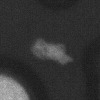

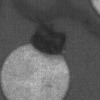

In [3]:
# 檢查資料夾內圖片

roses = list(data_dir.glob('ng/*'))

for image_path in roses[:2]:
    display.display(Image.open(str(image_path)))

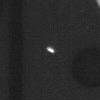

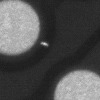

In [4]:
# 檢查資料夾內圖片

roses = list(data_dir.glob('ok/*'))

for image_path in roses[:2]:
    display.display(Image.open(str(image_path)))

In [5]:
# vars
BATCH_SIZE = 32
img_height = 100 #224
img_width = 100 #224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

#IMG_SIZE = (224, 224) # IMG_SIZE = (160, 160)

## 2. Load dataset with tf.data


In [6]:
# 以tf.data來讀取資料
# 同樣地，給定本地資料集的路徑。
# 2020-06-11版本(相同)
"""tf.data.Dataset.list_files
Note: The default behavior of this method is to return filenames in 
a non-deterministic random shuffled order. Pass a seed or shuffle=False 
to get results in a deterministic order.預設為random shuffle"""

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [7]:
# 檢查路徑、檔案

for f in list_ds.take(10):
  print(f.numpy())

b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI#4_19CC2018-04-000_3_NG007_Panel0009_ProcA3_Shot0_V16_D0_Img.jpg'
b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI#6_19CC2018-02-000_1_NG008_Panel0012_ProcA3_Shot0_V24_D0_Img.jpg'
b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI-C#3_19CJ2027-02-000_2_NG002_Panel0022_ProcA3_Col#1_Shot0_V18_D0_Img.jpg'
b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI#6_19CC2018-02-000_1_NG010_Panel0005_ProcA4_Shot0_V3_D0_Img.jpg'
b'/home/u3148947/.keras/datasets/uni/ok/CSPAFI#6_19CJ2028-02-000_1_NG021_Panel0012_ProcA4_Shot0_V3_D0_Img.jpg'
b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI#4_19CC2018-04-000_3_NG007_Panel0006_ProcA3_Shot0_V19_D0_Img.jpg'
b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI#6_19CJ2028-02-000_1_NG008_Panel0007_ProcA3_Shot0_V1_D0_Img.jpg'
b'/home/u3148947/.keras/datasets/uni/ok/CSPAFI#6_19CC2018-05-000_1_NG001_Panel0014_ProcA3_Shot0_V29_D0_Img.jpg'
b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI-C#3_19CC2018-04-000_1_NG003_Panel0010_ProcA3_Col#1_S

hit: 觀察有無shuffle變化

In [8]:
#增加了對類別排序而已sorted ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']

class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['ng' 'ok']


hit: 這裏可以請同學練習list基本原理與操作，往後資料呈現都會是以多維list or array方式。

hit:列表產生式與產生器的不同，`[] and ()`使用差異。

### Split the dataset into train and validation:

In [9]:
# train 80, val 20
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)



In [10]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

4498
1124


In [11]:
for t,v in zip(train_ds.take(2),val_ds.take(2)):
  print(t.numpy(), '\n')
  print(v.numpy())


b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI#4_19CC2018-04-000_3_NG002_Panel0018_ProcA4_Shot0_V21_D0_Img.jpg' 

b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI#4_19CC2018-04-000_3_NG007_Panel0009_ProcA3_Shot0_V16_D0_Img.jpg'
b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI-C#3_19CJ2027-02-000_1_NG006_Panel0009_ProcA4_Col#2_Shot0_V9_D0_Img.jpg' 

b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI#6_19CC2018-02-000_1_NG008_Panel0012_ProcA3_Shot0_V24_D0_Img.jpg'


In [12]:
#J Save train/val path list for later used

# len(list(val_ds))#1124 images for val_ds

count = 0
for element in val_ds.take(2):
    print(element) #tf.Tensor(b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI#6_19CC2018-05-000_1_NG011_Panel0006_ProcA3_Shot0_V5_D0_Img.jpg', shape=(), dtype=string)
    parts = tf.strings.split(element, os.path.sep)
    print('parts[] =', parts[-2]) # [-2]= dir name, [-1]= file name.
    count += 1   
print(count)
    

tf.Tensor(b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI#4_19CC2018-04-000_3_NG007_Panel0009_ProcA3_Shot0_V16_D0_Img.jpg', shape=(), dtype=string)
parts[] = tf.Tensor(b'ng', shape=(), dtype=string)
tf.Tensor(b'/home/u3148947/.keras/datasets/uni/ng/CSPAFI#6_19CC2018-02-000_1_NG008_Panel0012_ProcA3_Shot0_V24_D0_Img.jpg', shape=(), dtype=string)
parts[] = tf.Tensor(b'ng', shape=(), dtype=string)
2


### Converts a file path to an (img, label) pair:

In [13]:
#J tf2.3新版load_data/images使用one-hot, 所以後面的training 要把sparse_categorical_crossentropy換掉，變傳統的one-hot/categorical loss.
#新版：tf2.3
#
#J modify the get_label for runing at tf2.2 2020-08-06 2020-08-11 OKfortf2.2
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
    print('one_num:', one_num)
    # Integer encode the label
    return one_num
#     return tf.argmax(one_hot)
#   return tf.math.argmax(one_hot)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label



# hit: 請學員參考寫註解(英文)的方式，清晰易讀。中文註解主要作為課程說明與程式註解用途不同。

In [14]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds_map = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds_map = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)



one_num: Tensor("ArgMax:0", shape=(), dtype=int64)
one_num: Tensor("ArgMax:0", shape=(), dtype=int64)


In [15]:
for image, label in train_ds_map.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

"""tf2.3
Image shape:  (224, 224, 3)
Label:  2"""

Image shape:  (100, 100, 3)
Label:  0


'tf2.3\nImage shape:  (224, 224, 3)\nLabel:  2'

In [16]:
#sorted ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']
#sorted ['ng' 'ok']

#get_label('/home/u3148947/.keras/datasets/uni/ng/CSPAFI#4_19CC2018-04-000_3_NG003_Panel0011_ProcA4_Shot0_V28_D0_Img.jpg')
# <tf.Tensor: shape=(), dtype=int64, numpy=0>
get_label('imgs/ng_CSPAFI#4_19CC2018-04-000_3_NG003_Panel0012_ProcA4_Shot0_V11_D0_Img.jpg')

one_num: tf.Tensor(0, shape=(), dtype=int64)


<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [17]:
[img, label] = process_path('imgs/ok_CSPAFI#4_19CC2018-04-000_3_NG005_Panel0009_ProcA3_Shot0_V16_D0_Img.jpg')
print('label =', label)
tf.print(label)

one_num: tf.Tensor(0, shape=(), dtype=int64)
label = tf.Tensor(0, shape=(), dtype=int64)
0


In [18]:
# 參考

"""CLASS_NAMES的轉變

原本的CLASS_NAMES在讀取階段就以np array儲存，因此這裏很簡潔地使用array == 運算達到轉換成布林值格式。

==運算的意思是：比對array中全部元素的值，如果值相同該元素位置為True反之為False，最終返回一個相同大小的bool的array。

這個做法常在np或OpenCV做影像遮罩的時候使用，像是取二值化遮罩把128閾值設成 mask_img = img[<128]。
"""

def get_label_check(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
    
  print("parts\n", parts)
    
  # The second to last is the class-directory
  return parts[-2] == class_names

label_name_t = get_label_check('/Users/lsw/.keras/datasets/flower_photos/roses/9353111163_7a89b2df35_n.jpg')
print("label_name_t\n", label_name_t)

parts
 tf.Tensor(
[b'' b'Users' b'lsw' b'.keras' b'datasets' b'flower_photos' b'roses'
 b'9353111163_7a89b2df35_n.jpg'], shape=(8,), dtype=string)
label_name_t
 tf.Tensor([False False], shape=(2,), dtype=bool)


## 3. 使用tf.data訓練模型
### Basic methods for training

To train a model with this dataset you will want the data:

- To be well shuffled.
- To be batched.
- Batches to be available as soon as possible.

These features can be added using the tf.data API. For more details, see the Input Pipeline Performance guide.
https://render.githubusercontent.com/guide/performance/datasets



hit: 基本套路 洗牌 batch 正規化


In [19]:
#J
#新版：簡化很多
# def configure_for_performance(ds):
#   ds = ds.cache()
#   ds = ds.shuffle(buffer_size=1000)
#   ds = ds.batch(BATCH_SIZE)
#   ds = ds.prefetch(buffer_size=AUTOTUNE)
#   return ds

def configure_for_performance_cache(ds, cache=True):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
      print("Check cache to file:", cache)
    else:
      ds = ds.cache()
      print("Check cache in memory:", cache)
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

hit:

    ds.shuffle(buffer_size=1000)
    表示buffer維持一千張圖，隨機抽掉一張後，會由1001張補進維持1K張。因此完美的洗牌建議buffer要大於或等於dataset數量。

In [20]:
#J 新版：
train_ds_pre = configure_for_performance_cache(train_ds_map)
val_ds_pre = configure_for_performance_cache(val_ds_map)


Check cache in memory: True
Check cache in memory: True


### Visualize the data
You can visualize this dataset similarly to the one you created previously.

label from label_batch: tf.Tensor(0, shape=(), dtype=int64)
label from label_batch: tf.Tensor(0, shape=(), dtype=int64)
label from label_batch: tf.Tensor(0, shape=(), dtype=int64)
label from label_batch: tf.Tensor(1, shape=(), dtype=int64)
label from label_batch: tf.Tensor(0, shape=(), dtype=int64)
label from label_batch: tf.Tensor(0, shape=(), dtype=int64)
label from label_batch: tf.Tensor(1, shape=(), dtype=int64)
label from label_batch: tf.Tensor(1, shape=(), dtype=int64)
label from label_batch: tf.Tensor(0, shape=(), dtype=int64)


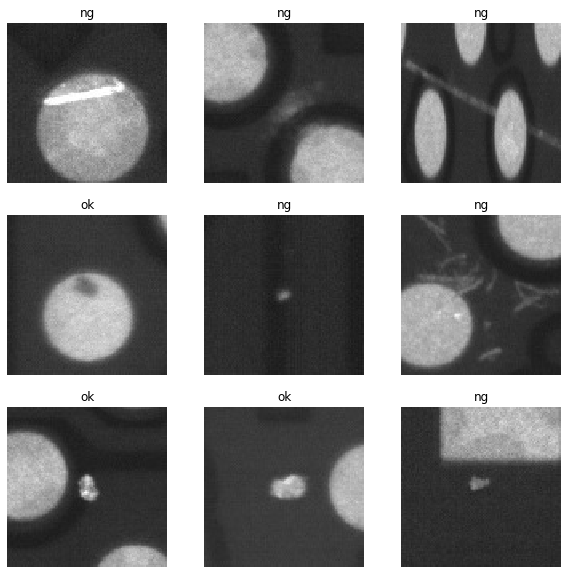

In [21]:
#J 新版：tf2.3

image_batch, label_batch = next(iter(train_ds_pre))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  print('label from label_batch:', label)
  plt.title(class_names[label])
  plt.axis("off")

In [22]:
#====================================================================================================#

### Predict on new data

https://www.tensorflow.org/tutorials/images/classification

* 這個模型僅到FC層不包含最後softmax，因此最後的分類結果要另外寫

In [ ]:
from tensorflow import keras

sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
#sunflower_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/Sunflower_sky_backdrop.jpg/1024px-Sunflower_sky_backdrop.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
"""Downloading data from https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/Sunflower_sky_backdrop.jpg/1024px-Sunflower_sky_backdrop.jpg
262144/261558 [==============================] - 1s 3us/step
This image most likely belongs to sunflowers with a 61.29 percent confidence."""

# 上面寫法會永遠保留第一次下載的影像，並且cache在.keras/datasets/Red_sunflower
# 因此，要使用新的影像做測試，需要刪除原本的檔案即可
!rm -rf ~/.keras/datasets/Red_sunflower


In [ ]:
#====================================================================================================#

In [ ]:
#====================================================================================================#

In [22]:
tf.config.experimental.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [23]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [24]:
#====================================================================================================#

In [ ]:
#====================================================================================================#

###  B. transfer learning with pretrained model

This scetion was modified from tf-transfer learning.ipynb example.


## (revise mbnV2 to ResNet50

In [25]:
# Create the base model from the pre-trained model MobileNetV2 ---> may to "ResNet50"

model_name = 'Xception' #'InceptionV3' "ResNet50" #'EfficientNetB7' for tf2.3

IMG_SHAPE = (img_height, img_width) + (3,)
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# Freeze the base_model
base_model.trainable = False


### todo: note for BatchNormalization()
We make sure to pass `training=False` when calling the base model, so that it runs in inference mode, so that batchnorm statistics don't get updated even after we unfreeze the base model for fine-tuning.


### todo
We add a Dropout layer before the classification layer, for regularization.

In [26]:
#J try to revise to a more functional Model()!!!
# revise above THREE cells!!

# ResNet50: Works!

num_classes = 2


# # inputs = tf.keras.Input(shape=(224, 224, 3))
# # bm_output = base_model(inputs, training=False)
# gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
# outputs = tf.keras.layers.Dense(num_classes)(gap2d)

# model = tf.keras.Model(base_model.input, outputs, name=model_name)


# J:20200914 redo fot FIX BatchNormalization of base model. by set base_model with 'inputs,training=False'
inputs = tf.keras.Input(shape=(IMG_SHAPE))
bm_output = base_model(inputs, training=False)

gap2d = tf.keras.layers.GlobalAveragePooling2D()(bm_output)
dropout = tf.keras.layers.Dropout(0.2)(gap2d)#J add dropout
outputs = tf.keras.layers.Dense(num_classes)(dropout)

model = tf.keras.Model(inputs, outputs, name=model_name)

In [27]:
len(model.trainable_variables)

2

In [28]:
model.name

'Xception'

In [29]:
# Let's take a look at the base model architecture
model.summary()

Model: "Xception"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
xception (Model)             (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 20,865,578
Trainable params: 4,098
Non-trainable params: 20,861,480
_________________________________________________________________


In [30]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 49, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [31]:
base_learning_rate = 0.0001 # org. 0.0001 = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#tf.losses.SparseCategoricalCrossentropy(from_logits=True) we are not used one-hot label.

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [32]:
%%time
initial_epochs = 50

loss0, accuracy0 = model.evaluate(val_ds_pre)

36/36 [==============================] - 1s 26ms/step - loss: 2.2364 - accuracy: 0.5036
CPU times: user 5.13 s, sys: 2.91 s, total: 8.04 s
Wall time: 7.15 s


In [33]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.24
initial accuracy: 0.50


In [34]:
%%time
history = model.fit(train_ds_pre,
                    epochs=initial_epochs,
                    validation_data=val_ds_pre)

Epoch 1/50
141/141 [==============================] - 5s 36ms/step - loss: 2.5124 - accuracy: 0.5709 - val_loss: 1.5433 - val_accuracy: 0.5988
Epoch 2/50
141/141 [==============================] - 6s 39ms/step - loss: 2.1833 - accuracy: 0.6125 - val_loss: 1.2101 - val_accuracy: 0.6423
Epoch 3/50
141/141 [==============================] - 2s 17ms/step - loss: 1.9014 - accuracy: 0.6274 - val_loss: 1.0650 - val_accuracy: 0.6628
Epoch 4/50
141/141 [==============================] - 2s 17ms/step - loss: 1.7823 - accuracy: 0.6432 - val_loss: 0.9937 - val_accuracy: 0.6744
Epoch 5/50
141/141 [==============================] - 2s 17ms/step - loss: 1.6027 - accuracy: 0.6576 - val_loss: 0.8950 - val_accuracy: 0.6877
Epoch 6/50
141/141 [==============================] - 2s 17ms/step - loss: 1.5426 - accuracy: 0.6627 - val_loss: 0.8535 - val_accuracy: 0.7011
Epoch 7/50
141/141 [==============================] - 2s 17ms/step - loss: 1.4223 - accuracy: 0.6667 - val_loss: 0.8105 - val_accuracy: 0.7082

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

base model and training pahse: Xception_top-layer_lr0.0001_e50


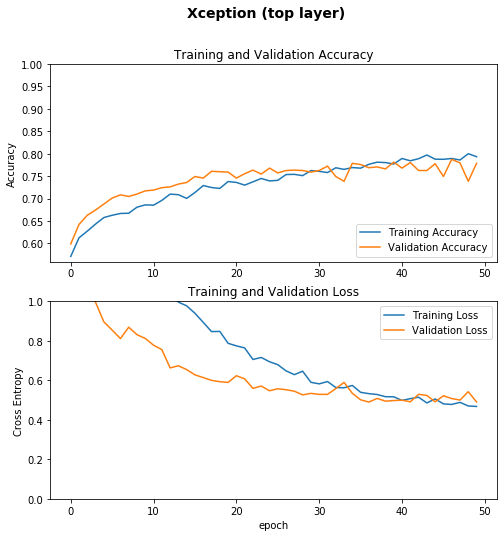

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize=(8, 8), num=model_name)
fig.suptitle(model_name + ' (top layer)', fontsize=14, fontweight='bold')
print("base model and training pahse: {}".format(model_name + '_top-layer' + '_lr' + str(base_learning_rate) + '_e' + str(initial_epochs) ))


plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning

### Un-freeze the top layers of the model

In [36]:
base_model.trainable = True

In [37]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100# this is LAYER position NOT epoch!!!

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  132


In [38]:
len(model.trainable_variables)

41

HIT: RaseNet50 somehow展開模型後，使得base base model消失，因此使用上述方法對目前記憶體中的model是沒有作用的，

do: for layer in model.layer[:fine_tune_at]:
    layer,trainable = False
    
end: its because the "layer.trainable =  False" has one more space!! right is "layer.trainable = False"

### Compile the model (fine tuning)

In [39]:
lr=base_learning_rate/1000
print("lr_base = {:.12f}\nlr_tune = {:.12f}\n".format(base_learning_rate, lr))

model.compile(#loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=lr),# adm -> RMSprop??, original is /10 may to /100 to reduce the overfitting
              metrics=['accuracy'])

lr_base = 0.000100000000
lr_tune = 0.000000100000



In [40]:
model.summary()

Model: "Xception"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
xception (Model)             (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 20,865,578
Trainable params: 9,482,442
Non-trainable params: 11,383,136
_________________________________________________________________


In [41]:
len(model.trainable_variables)

41

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [42]:
%%time
fine_tune_epochs = 200
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds_pre,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds_pre)

Epoch 50/250
141/141 [==============================] - 6s 44ms/step - loss: 0.4604 - accuracy: 0.7904 - val_loss: 0.4874 - val_accuracy: 0.7758
Epoch 51/250
141/141 [==============================] - 6s 45ms/step - loss: 0.4484 - accuracy: 0.8006 - val_loss: 0.4862 - val_accuracy: 0.7758
Epoch 52/250
141/141 [==============================] - 6s 45ms/step - loss: 0.4498 - accuracy: 0.8077 - val_loss: 0.4842 - val_accuracy: 0.7794
Epoch 53/250
141/141 [==============================] - 3s 24ms/step - loss: 0.4438 - accuracy: 0.8032 - val_loss: 0.4833 - val_accuracy: 0.7785
Epoch 54/250
141/141 [==============================] - 3s 24ms/step - loss: 0.4497 - accuracy: 0.8037 - val_loss: 0.4827 - val_accuracy: 0.7811
Epoch 55/250
141/141 [==============================] - 3s 24ms/step - loss: 0.4365 - accuracy: 0.8081 - val_loss: 0.4837 - val_accuracy: 0.7794
Epoch 56/250
141/141 [==============================] - 4s 27ms/step - loss: 0.4338 - accuracy: 0.8104 - val_loss: 0.4841 - val_ac

In [43]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

base model and training pahse: Xception_top-100layer_lr1.0000000000000001e-07_e250


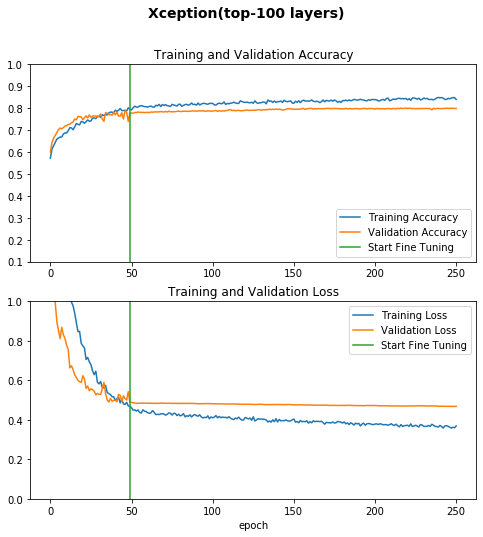

In [44]:
fig = plt.figure(figsize=(8, 8), num=model_name)
fig.suptitle(model_name + '(top-100 layers)', fontsize=14, fontweight='bold')
print("base model and training pahse: {}".format(model_name + '_top-100layer' + '_lr' + str(lr) + '_e' + str(total_epochs) ))


plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.1, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [72]:
#Saving a Keras model:
today_date = datetime.today().strftime('%Y-%m-%d-%H-%M')
name_the_model = dataset_name.decode("utf-8") + '_' + model_name + '_' + 'bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_h' + str(img_height) + '_' + 'e' + str(fine_tune_epochs) + '_' + today_date + '.h5'

# current_model_name = 'uni-cj0713-tf22-Xception_top-100layer_lr0.0001decay_do0.4_e404_20200916.h5'
model.save(name_the_model)
print('Save to :', name_the_model)

Save to : uni_Xception_bs32_w100_h100_e200_2020-09-18-22-40.h5


## Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

沒有另外製作test data，改用val測試

In [ ]:
%%time
test_dataset = val_ds_pre
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

In [ ]:
# image_batch, label_batch = val_ds_pre.take(1) ???? 

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch) #J removed the (image_batch) of xx_batch(image_batch).flatten()
                                                  #J then, softmax/sigmoid is same, and key is argmax(L,1)

# Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
predictions = tf.nn.softmax(predictions)#J try to fix the logts not correct?! but not works/
predictions = tf.where(predictions < 0.5, 0, 1) #J if less then 0.5 set to 0, else set to 1.
predictions = tf.argmax(predictions, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(30):
  ax = plt.subplot(6, 6, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))

  #org method
#   plt.title(class_names[predictions[i]])
    
  #J C method
  if predictions[i] == label_batch[i]:
      plt.title(class_names[predictions[i]])
  else:
      plt.title(class_names[predictions[i]],fontweight='bold', color='red')

  #J pythonic method 1
#   color = "green" if predictions[i] == label_batch[i] else "red"
#   plt.title(class_names[predictions[i]], color=color)

  #J pythonic method 2
#   plt.title(class_names[predictions[i]], color=("green" if predictions[i] == label_batch[i] else "red"))

  plt.axis("off")

In [ ]:
#====================================================================================================#

### Save model


In [ ]:
#Saving a Keras model:
current_model_name = 'uni-cj0713-tf22-ren50-e60-20200831.h5'
model.save(current_model_name)

### Load model and inference

In [ ]:
#Loading the model back:
model_back = tf.keras.models.load_model(current_model_name)

In [ ]:
#test load back model
model = model_back

# sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
# #sunflower_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/Sunflower_sky_backdrop.jpg/1024px-Sunflower_sky_backdrop.jpg"
# sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

# img = tf.keras.preprocessing.image.load_img(
#     sunflower_path, target_size=(img_height, img_width)
# )


# ngok_path = "imgs/ng_CSPAFI#4_19CC2018-04-000_3_NG003_Panel0012_ProcA4_Shot0_V11_D0_Img.jpg"
ngok_path = 'imgs/ok_CSPAFI#4_19CC2018-04-000_3_NG005_Panel0009_ProcA3_Shot0_V16_D0_Img.jpg'

img = tf.keras.preprocessing.image.load_img(
    ngok_path, target_size=(img_height, img_width)
)


img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
tf.print(score)
# confidence of two classes
# [9.06327458e-09 1]

In [ ]:
"""Downloading data from https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/Sunflower_sky_backdrop.jpg/1024px-Sunflower_sky_backdrop.jpg
262144/261558 [==============================] - 1s 3us/step
This image most likely belongs to sunflowers with a 61.29 percent confidence."""

# 上面寫法會永遠保留第一次下載的影像，並且cache在.keras/datasets/Red_sunflower
# 因此，要使用新的影像做測試，需要刪除原本的檔案即可
!rm -rf ~/.keras/datasets/Red_sunflower

In [ ]:
#model.summary()

### tf.explan

#### 貌似跟模型有關，完整模型NN-Interpretability-tf2.ipynb(with TF2.2)是ＯＫ的 所以也有可能是tf版本問題

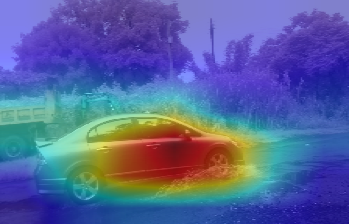

#### 2020-08-08 TF version PROBLEM!!!
* tf-explain can not run with tf2.3 but tf2.2 is fine.
* tf.data one-hot/argmax work with tf2.3 but NOT tf2.2.
* 
* workaround: (1)create tf.data in tf2.3, (2)train model in tf2.2 or 2.3, (3)then tf-explain in tf2.2!

In [ ]:
#J tf-explain 對subgraph的模型無法處理，需要讀入後重新編成序列是模型
""" ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_1_5:0", 
shape=(None, 224, 224, 3), dtype=float32) at layer "input_1". The following previous 
layers were accessed without issue: []

https://github.com/sicara/tf-explain/issues/138

略有不同，
ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_37:0", 
shape=(None, 224, 224, 3), dtype=float32) at layer "input_37". The following previous 
layers were accessed without issue: []
變成是mbv2本身第一層輸入無法連結，而不是外加的輸入處理。換模型測試避開mb特殊外加做法。

"""

model = tf.keras.models.load_model(current_model_name)
# model.summary()

In [ ]:
#!pip3 install tf-explain

In [ ]:
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.smoothgrad import SmoothGrad
from tf_explain.core.vanilla_gradients import VanillaGradients
from tf_explain.core.integrated_gradients import IntegratedGradients
# SmoothGrad, VanillaGradients cannot use lauer_anme


In [ ]:
#增加了對類別排序而已sorted ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']
# 0,1,2,3,4

#tf-explain parameters
IMAGE_PATH = '/home/u3148947/.keras/datasets/uni/ok/CSPAFI#4_19CC2018-04-000_3_NG005_Panel0009_ProcA3_Shot0_V16_D0_Img.jpg'#'./Red_sunflower.jpg'#'./0_in.jpg' # 37.jpg, 0_in.jpg, cat.jpg
LAYER_NAME = 'conv5_block3_out' #J if non given default is last 4D layer of model
# LAYER_NAME = None

# Load pretrained model or your own
# model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=True) # .vgg16.VGG16 -> resnet50.ResNet50

#Loading the model back:
model = tf.keras.models.load_model(current_model_name)


#In memory model: just do not thing!
# model = in-memory-Model
#In memory model: just do not thing!


# Load a sample image (or multiple ones)
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
data = ([img], None)


# Start explainer

# explainer = OcclusionSensitivity()
# grid = explainer.explain(validation_data=data, model=model, patch_size=4, class_index=3) 


explainer = GradCAM()
grid = explainer.explain(data, model, colormap=cv2.COLORMAP_JET, image_weight=0.5, class_index=0)  # 281 is the tabby cat index in ImageNet

# explainer = GradCAM()
# grid = explainer.explain(validation_data=data, model=model, layer_name=LAYER_NAME, class_index=3)  # 281 is the tabby cat index in ImageNet

# explainer = SmoothGrad()
# grid = explainer.explain(validation_data=data, model=model, class_index=1)

# explainer = IntegratedGradients()
# grid = explainer.explain(validation_data=data, model=model, class_index=281) 
#479: 'car wheel',


#J 
#Save CAM image
out_name = 'tf-explain_GCAM_' + LAYER_NAME + '.png'
explainer.save(grid, ".", out_name)

#Show it now
import ipyplot
img_org = cv2.imread(IMAGE_PATH)
img_org = cv2.resize(img_org, (224, 224), interpolation=cv2.INTER_CUBIC)
img_org = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)

# img_cam = cv2.cvtColor(grid, cv2.COLOR_BGR2RGB)
img_cam = cv2.cvtColor(grid, cv2.COLOR_RGB2BGR)

ipyplot.plot_images([img_org, img_cam],['image', 'feature'], max_images=20, img_width=250)

## copy A. Grad CAM with raw Implementation

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

IMAGE_PATH = '/home/u3148947/.keras/datasets/uni/ok/CSPAFI#4_19CC2018-04-000_3_NG005_Panel0009_ProcA3_Shot0_V16_D0_Img.jpg'#'./Red_sunflower.jpg'#'./0_in.jpg' # 37.jpg, 0_in.jpg, cat.jpg
#'./Red_sunflower.jpg'#'./0_in.jpg' # 37.jpg, 0_in.jpg, cat.jpg
LAYER_NAME = 'conv5_block3_out' # vgg16's block5_conv3 -> resnet50's conv5_block3_out

""" imagenet1000_clsidx_to_labels.txt

https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

281: 'tabby, tabby cat',
479: 'car wheel',

"""
CAM_CLASS_INDEX = 0 #479 #281 # CCI

img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)

#org
# model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=True) # .vgg16.VGG16 -> resnet50.ResNet50

#Loading the model back:
model = tf.keras.models.load_model(current_model_name)


grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    loss = predictions[:, CAM_CLASS_INDEX]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (224, 224))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

# output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.6, cam, 0.4, 0)# change original image color.
output_image = cv2.addWeighted(img.astype('uint8'), 0.6, cam, 0.4, 0)

#Save CAM image
out_name = IMAGE_PATH + '_GCAM_' + LAYER_NAME + '_CCI-' + str(CAM_CLASS_INDEX) + '.png'
cv2.imwrite(out_name, output_image) # OK with RGB format

#Show it now
plt.imshow(output_image)
plt.title(out_name)
plt.show()

#Show it now
import ipyplot
img_org = cv2.imread(IMAGE_PATH)
img_org = cv2.resize(img_org, (224, 224), interpolation=cv2.INTER_CUBIC)
img_org = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)
img_cam = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
# img_cam = output_image


ipyplot.plot_images([img_org, img_cam],['image', 'active'], max_images=20, img_width=224)
print("CAM for ID:", CAM_CLASS_INDEX)
print("class_names: 0 ,1 , 2 \n",  class_names)

# #J refunction this

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

def GCAM(model, IMAGE_PATH, LAYER_NAME, img, CAM_CLASS_INDEX):

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img]))
        loss = predictions[:, CAM_CLASS_INDEX]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.ones(output.shape[0: 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

    # output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.6, cam, 0.4, 0)# change original image color.
    output_image = cv2.addWeighted(img.astype('uint8'), 0.6, cam, 0.4, 0)

    #Save CAM image
    out_name = IMAGE_PATH + '_GCAM_' + LAYER_NAME + '_CCI-' + str(CAM_CLASS_INDEX) + '.jpg'
    cv2.imwrite(out_name, output_image) # OK with RGB format
    print("Save CAM to:", out_name)


    #return result image
    return cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)#output_image #somehow cv2 issue


In [ ]:
model = tf.keras.models.load_model(current_model_name)

IMAGE_PATH = 'imgs/ok_CSPAFI#4_19CC2018-04-000_3_NG005_Panel0009_ProcA3_Shot0_V16_D0_Img.jpg'#'./Red_sunflower.jpg'#'./0_in.jpg' # 37.jpg, 0_in.jpg, cat.jpg
LAYER_NAME = 'conv5_block3_out' # vgg16's block5_conv3 -> resnet50's conv5_block3_out
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
# CAM_CLASS_INDEX = 2 #479 #281 # CCI

p = []
for i in range(num_classes):
    tempimg = GCAM(model,IMAGE_PATH,LAYER_NAME,img,CAM_CLASS_INDEX=i)
    p.append(tempimg)

ipyplot.plot_images([img.astype('uint8'), p[0], p[1]],['image', 'activeID-0', 'activeID-1', 'activeID-2'], max_images=20, img_width=224)
# print("CAM for ID:", CAM_CLASS_INDEX)
print("[CAM for each class name]")
print("class_names: 0 ,1 \n",  class_names)
print(type(p), np.array(p).shape)

In [ ]:
%%time

imgs_dir = pathlib.Path('okng/ng/')
imgs_list = list(imgs_dir.glob('*.jpg'))

model = tf.keras.models.load_model(current_model_name)
LAYER_NAME = 'conv5_block3_out' # vgg16's block5_conv3 -> resnet50's conv5_block3_out
CAM_CLASS_INDEX = 2 #479 #281 # CCI

p = []
for ip in imgs_list:
    print(ip)  
    IMAGE_PATH = str(ip)
    img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    for i in range(num_classes):
        tempimg = GCAM(model,IMAGE_PATH,LAYER_NAME,img,CAM_CLASS_INDEX=i)
        p.append(tempimg)

        
#TODO
# all_cam = [[GCAM(model,LAYER_NAME,img,CAM_CLASS_INDEX=i)] for i in range(num_classes) for path in imgs_list]



In [ ]:
('okng/ok/')
Wall time: 33min 42s
('okng/ng/')
Wall time: 45min 22s

### Performance

Note: This section just shows a couple of easy tricks that may help performance. For an in depth guide see Input Pipeline Performance.

To investigate, first here's a function to check the performance of our datasets:

In [ ]:
import time
default_timeit_steps = 100 #1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))


Let's compare the speed of the two data generators:

In [ ]:
# `keras.preprocessing`
timeit(train_data_gen)


In [ ]:
# `tf.data`
timeit(train_ds)

A large part of the performance gain comes from the use of .cache.

In [ ]:
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)


If the dataset doesn't fit in memory use a cache file to maintain some of the advantages:


In [ ]:
filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecache_ds)

# 第一次cache會比較慢

In [ ]:
!ls -lh

In [ ]:
!ls -lh ~/.keras/dataset

In [ ]:
!ls -lah ~/.keras/datasets

In [ ]:
!du -sh ~/.keras/datasets/flower_photos

hit: 2.1G tf.data. cache的檔案似乎是原始檔案的九倍大。

## Reference:


* https://www.tensorflow.org/tutorials/load_data/tfrecord [如何製作TFRecord檔案/實作1]的原始碼與教學

* https://www.tensorflow.org/tutorials/load_data/images [實作2 flowers dataet] 主要原始碼
* https://www.tensorflow.org/guide/data [實作2 flowers dataet] 參考Create the image.ImageDataGenerator演示，但此演示較簡略僅參考未使用在本教學中
* http://medium.com/@lufor129/tensorflow-圖片數據增強-一-tfrecord-轉換-bd51a70277c  [實作2]的原始碼
* https://dotblogs.com.tw/shaynling/2017/11/20/150241 【Python】TensorFlow學習筆記(二)：初探 TFRecord 夏恩 [實作2]的原始碼


** 注意：如果是在有conda環境下，請注意啟動的環境是否正確。目前twcc+cntr+anaconda+base env.時，由於bashrc path直接導入base環境的pytroch，造成原有系統的tensorflow搜尋不到。請修改bashrc中的path路徑，或是根本上不要在base上安裝，要新建mytrochenv來分離安裝。